In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import lightgbm
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap
sns.set_context("poster")
shap.initjs()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
model_path = "../models"
image_path = "../images"

In [3]:
dat = pd.read_pickle("../data/cleandata2.pkl")
# print available features
print(dat.columns)

Index(['PARID', 'SALEDATE', 'PRICE', 'GRADERANK', 'CDURANK', 'SCHOOLRANK',
       'LOTAREA', 'FINISHEDLIVINGAREA', 'STORIES', 'BEDROOMS', 'ADJUSTBATHS',
       'BSMTGARAGE', 'FIREPLACES', 'YEARBLT', 'FAIRMARKETTOTAL', 'BASEMENT',
       'MUNICODE', 'EXTFINISH_DESC', 'STYLEDESC', 'NEIGHCODE', 'NEIGHDESC',
       'PROPERTYZIP', 'LATITUDE', 'LONGITUDE', 'CENSUS_TRACT', 'ANXIETY',
       'OLD', 'POOR', 'VACANT'],
      dtype='object')


In [4]:
# data engineering
origin_date = "2010-01-01"  # let us use this date as the origin
dat["TIME"] = (dat["SALEDATE"] - pd.to_datetime(origin_date)).dt.days / 30
dat["MONTH"] = dat["SALEDATE"].dt.month
dat["AGE"] = np.maximum(dat["SALEDATE"].dt.year - dat["YEARBLT"], 0)
dat["LOGPRICE"] = np.log(dat["PRICE"])
dat["LOGFAIRMARKETTOTAL"] = np.log(dat["FAIRMARKETTOTAL"])
dat["LOGLOTAREA"] = np.log(dat["LOTAREA"])
dat["LOGFINISHEDLIVINGAREA"] = np.log(dat["FINISHEDLIVINGAREA"])
dat["PRICEPERSQFT"] = dat["FAIRMARKETTOTAL"] / dat["LOTAREA"]
# let us keep all data lower than 1M to avoid outlier
dat = dat.query("PRICE < %d" % 1e6)

# segment the house based on FAIRMARKETTOTAL of 2012
tiers_cut = dat["FAIRMARKETTOTAL"].quantile([0.05, 0.35, 0.65, 0.95]).tolist()
dat["TIERS"] = pd.cut(dat["FAIRMARKETTOTAL"], tiers_cut, labels=["Bottom", "Middle", "Top"])

In [5]:
# convert object column to category type
for col in ["NEIGHCODE", "EXTFINISH_DESC", "STYLEDESC", "MUNICODE"]:
    dat[col] = dat[col].astype("category")

In [6]:
# split the data into training and testing based on 80-20 rule
train_dat, valid_dat = train_test_split(dat, train_size=0.8, random_state=2021)
ntrain, nvalid = len(train_dat), len(valid_dat)
print("ntrain = %d, ntest = %d" % (ntrain, nvalid))

ntrain = 154303, ntest = 38576


In [7]:
# continuous features
x_feats = [
    'TIME', 'GRADERANK', 'CDURANK', 'SCHOOLRANK',
    'STORIES', 'BEDROOMS', 'ADJUSTBATHS', 'BSMTGARAGE', 'FIREPLACES', 'YEARBLT', 'BASEMENT',
    'LOGLOTAREA', 'LOGFINISHEDLIVINGAREA', 'PRICEPERSQFT', "AGE",
    'LATITUDE', 'LONGITUDE', 'ANXIETY', 'OLD', 'POOR', 'VACANT'
]

# nominal features
x_categorical_feats = [
    'NEIGHCODE', 'EXTFINISH_DESC', 'STYLEDESC', 'MONTH', 'TIERS'
]

# target variable log price
y_feats = [
    "LOGPRICE"
]


In [8]:
train_dataloader = lightgbm.Dataset(data=train_dat[x_feats + x_categorical_feats],
                                    label=train_dat[y_feats],
                                    categorical_feature=x_categorical_feats)

valid_dataloader = lightgbm.Dataset(data=valid_dat[x_feats + x_categorical_feats],
                                     label=valid_dat[y_feats],
                                     categorical_feature=x_categorical_feats)

In [9]:
# use the parameter
parameters = {
    'objective': 'mae',
    'metric': ['rmse'],
    'boosting': 'gbdt',
    'num_leaves': 32,
    'min_child_samples': 69,
    'feature_fraction': 0.6597079764069385,
    'bagging_fraction': 0.6171731471091209,
    'bagging_freq': 4,
    'lambda_l1': 3.5479988320298905,
    'lambda_l2': 3.503857243823598,
    'learning_rate': 0.021626597418816215,
    'verbose': 0,
    'seed': 2021
}

In [10]:
model = lightgbm.train(params=parameters,
                       train_set=train_dataloader,
                       valid_sets=valid_dataloader,
                       num_boost_round=10000,
                       early_stopping_rounds=1000)

Using categorical_feature in Dataset.


[1]	valid_0's rmse: 0.933902
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's rmse: 0.925676
[3]	valid_0's rmse: 0.916591
[4]	valid_0's rmse: 0.909551
[5]	valid_0's rmse: 0.902254
[6]	valid_0's rmse: 0.8948
[7]	valid_0's rmse: 0.887668
[8]	valid_0's rmse: 0.880758
[9]	valid_0's rmse: 0.874271
[10]	valid_0's rmse: 0.867833
[11]	valid_0's rmse: 0.861752
[12]	valid_0's rmse: 0.855402
[13]	valid_0's rmse: 0.849362
[14]	valid_0's rmse: 0.843799
[15]	valid_0's rmse: 0.838221
[16]	valid_0's rmse: 0.832689
[17]	valid_0's rmse: 0.827456
[18]	valid_0's rmse: 0.822231
[19]	valid_0's rmse: 0.816847
[20]	valid_0's rmse: 0.811694
[21]	valid_0's rmse: 0.80628
[22]	valid_0's rmse: 0.801431
[23]	valid_0's rmse: 0.796852
[24]	valid_0's rmse: 0.79268
[25]	valid_0's rmse: 0.78815
[26]	valid_0's rmse: 0.782915
[27]	valid_0's rmse: 0.778269
[28]	valid_0's rmse: 0.773333
[29]	valid_0's rmse: 0.768899
[30]	valid_0's rmse: 0.764109
[31]	valid_0's rmse: 0.760469
[32]	valid_0's rmse: 

[268]	valid_0's rmse: 0.582474
[269]	valid_0's rmse: 0.582443
[270]	valid_0's rmse: 0.582353
[271]	valid_0's rmse: 0.582292
[272]	valid_0's rmse: 0.582235
[273]	valid_0's rmse: 0.582185
[274]	valid_0's rmse: 0.582145
[275]	valid_0's rmse: 0.582005
[276]	valid_0's rmse: 0.581814
[277]	valid_0's rmse: 0.581725
[278]	valid_0's rmse: 0.581691
[279]	valid_0's rmse: 0.581654
[280]	valid_0's rmse: 0.581545
[281]	valid_0's rmse: 0.581474
[282]	valid_0's rmse: 0.581426
[283]	valid_0's rmse: 0.581333
[284]	valid_0's rmse: 0.581232
[285]	valid_0's rmse: 0.581159
[286]	valid_0's rmse: 0.58109
[287]	valid_0's rmse: 0.580958
[288]	valid_0's rmse: 0.580927
[289]	valid_0's rmse: 0.580802
[290]	valid_0's rmse: 0.580731
[291]	valid_0's rmse: 0.580696
[292]	valid_0's rmse: 0.580652
[293]	valid_0's rmse: 0.580621
[294]	valid_0's rmse: 0.580469
[295]	valid_0's rmse: 0.580425
[296]	valid_0's rmse: 0.580404
[297]	valid_0's rmse: 0.580361
[298]	valid_0's rmse: 0.580331
[299]	valid_0's rmse: 0.580301
[300]	val

[533]	valid_0's rmse: 0.573177
[534]	valid_0's rmse: 0.573175
[535]	valid_0's rmse: 0.573144
[536]	valid_0's rmse: 0.57314
[537]	valid_0's rmse: 0.573132
[538]	valid_0's rmse: 0.573087
[539]	valid_0's rmse: 0.573068
[540]	valid_0's rmse: 0.573025
[541]	valid_0's rmse: 0.573008
[542]	valid_0's rmse: 0.57299
[543]	valid_0's rmse: 0.572991
[544]	valid_0's rmse: 0.572987
[545]	valid_0's rmse: 0.572979
[546]	valid_0's rmse: 0.57297
[547]	valid_0's rmse: 0.572943
[548]	valid_0's rmse: 0.572915
[549]	valid_0's rmse: 0.572906
[550]	valid_0's rmse: 0.572897
[551]	valid_0's rmse: 0.572885
[552]	valid_0's rmse: 0.572877
[553]	valid_0's rmse: 0.572866
[554]	valid_0's rmse: 0.572856
[555]	valid_0's rmse: 0.572852
[556]	valid_0's rmse: 0.572842
[557]	valid_0's rmse: 0.572841
[558]	valid_0's rmse: 0.572826
[559]	valid_0's rmse: 0.572809
[560]	valid_0's rmse: 0.572766
[561]	valid_0's rmse: 0.572757
[562]	valid_0's rmse: 0.57275
[563]	valid_0's rmse: 0.572721
[564]	valid_0's rmse: 0.572724
[565]	valid_

[798]	valid_0's rmse: 0.570228
[799]	valid_0's rmse: 0.570223
[800]	valid_0's rmse: 0.570221
[801]	valid_0's rmse: 0.570222
[802]	valid_0's rmse: 0.570181
[803]	valid_0's rmse: 0.570179
[804]	valid_0's rmse: 0.57018
[805]	valid_0's rmse: 0.570146
[806]	valid_0's rmse: 0.570132
[807]	valid_0's rmse: 0.570132
[808]	valid_0's rmse: 0.570119
[809]	valid_0's rmse: 0.570118
[810]	valid_0's rmse: 0.570114
[811]	valid_0's rmse: 0.570115
[812]	valid_0's rmse: 0.570092
[813]	valid_0's rmse: 0.570083
[814]	valid_0's rmse: 0.57008
[815]	valid_0's rmse: 0.570076
[816]	valid_0's rmse: 0.570071
[817]	valid_0's rmse: 0.570072
[818]	valid_0's rmse: 0.570057
[819]	valid_0's rmse: 0.570044
[820]	valid_0's rmse: 0.57004
[821]	valid_0's rmse: 0.57003
[822]	valid_0's rmse: 0.570033
[823]	valid_0's rmse: 0.570028
[824]	valid_0's rmse: 0.570029
[825]	valid_0's rmse: 0.570027
[826]	valid_0's rmse: 0.570025
[827]	valid_0's rmse: 0.570022
[828]	valid_0's rmse: 0.57002
[829]	valid_0's rmse: 0.570016
[830]	valid_0

[1061]	valid_0's rmse: 0.568524
[1062]	valid_0's rmse: 0.568522
[1063]	valid_0's rmse: 0.568509
[1064]	valid_0's rmse: 0.568506
[1065]	valid_0's rmse: 0.568505
[1066]	valid_0's rmse: 0.568505
[1067]	valid_0's rmse: 0.568504
[1068]	valid_0's rmse: 0.568486
[1069]	valid_0's rmse: 0.568461
[1070]	valid_0's rmse: 0.56845
[1071]	valid_0's rmse: 0.56845
[1072]	valid_0's rmse: 0.568445
[1073]	valid_0's rmse: 0.568446
[1074]	valid_0's rmse: 0.568447
[1075]	valid_0's rmse: 0.568448
[1076]	valid_0's rmse: 0.568435
[1077]	valid_0's rmse: 0.568434
[1078]	valid_0's rmse: 0.568427
[1079]	valid_0's rmse: 0.568408
[1080]	valid_0's rmse: 0.568407
[1081]	valid_0's rmse: 0.568404
[1082]	valid_0's rmse: 0.568399
[1083]	valid_0's rmse: 0.568398
[1084]	valid_0's rmse: 0.568399
[1085]	valid_0's rmse: 0.568393
[1086]	valid_0's rmse: 0.568382
[1087]	valid_0's rmse: 0.56838
[1088]	valid_0's rmse: 0.568378
[1089]	valid_0's rmse: 0.568371
[1090]	valid_0's rmse: 0.568361
[1091]	valid_0's rmse: 0.56836
[1092]	valid

[1317]	valid_0's rmse: 0.567226
[1318]	valid_0's rmse: 0.567222
[1319]	valid_0's rmse: 0.567217
[1320]	valid_0's rmse: 0.567213
[1321]	valid_0's rmse: 0.567189
[1322]	valid_0's rmse: 0.567191
[1323]	valid_0's rmse: 0.567192
[1324]	valid_0's rmse: 0.567193
[1325]	valid_0's rmse: 0.567182
[1326]	valid_0's rmse: 0.56718
[1327]	valid_0's rmse: 0.56718
[1328]	valid_0's rmse: 0.567179
[1329]	valid_0's rmse: 0.56718
[1330]	valid_0's rmse: 0.567178
[1331]	valid_0's rmse: 0.567177
[1332]	valid_0's rmse: 0.567181
[1333]	valid_0's rmse: 0.567169
[1334]	valid_0's rmse: 0.567164
[1335]	valid_0's rmse: 0.56715
[1336]	valid_0's rmse: 0.567142
[1337]	valid_0's rmse: 0.567141
[1338]	valid_0's rmse: 0.56714
[1339]	valid_0's rmse: 0.567137
[1340]	valid_0's rmse: 0.567133
[1341]	valid_0's rmse: 0.567134
[1342]	valid_0's rmse: 0.567134
[1343]	valid_0's rmse: 0.567134
[1344]	valid_0's rmse: 0.567134
[1345]	valid_0's rmse: 0.567132
[1346]	valid_0's rmse: 0.567128
[1347]	valid_0's rmse: 0.567123
[1348]	valid_

[1574]	valid_0's rmse: 0.566444
[1575]	valid_0's rmse: 0.56644
[1576]	valid_0's rmse: 0.566439
[1577]	valid_0's rmse: 0.566438
[1578]	valid_0's rmse: 0.566438
[1579]	valid_0's rmse: 0.566437
[1580]	valid_0's rmse: 0.566435
[1581]	valid_0's rmse: 0.566433
[1582]	valid_0's rmse: 0.566431
[1583]	valid_0's rmse: 0.566427
[1584]	valid_0's rmse: 0.566425
[1585]	valid_0's rmse: 0.566428
[1586]	valid_0's rmse: 0.566426
[1587]	valid_0's rmse: 0.56642
[1588]	valid_0's rmse: 0.566422
[1589]	valid_0's rmse: 0.566423
[1590]	valid_0's rmse: 0.566422
[1591]	valid_0's rmse: 0.56642
[1592]	valid_0's rmse: 0.566419
[1593]	valid_0's rmse: 0.566409
[1594]	valid_0's rmse: 0.566393
[1595]	valid_0's rmse: 0.566394
[1596]	valid_0's rmse: 0.566391
[1597]	valid_0's rmse: 0.566384
[1598]	valid_0's rmse: 0.566384
[1599]	valid_0's rmse: 0.566381
[1600]	valid_0's rmse: 0.566381
[1601]	valid_0's rmse: 0.566378
[1602]	valid_0's rmse: 0.566377
[1603]	valid_0's rmse: 0.566377
[1604]	valid_0's rmse: 0.566377
[1605]	vali

[1831]	valid_0's rmse: 0.565923
[1832]	valid_0's rmse: 0.565918
[1833]	valid_0's rmse: 0.565919
[1834]	valid_0's rmse: 0.565914
[1835]	valid_0's rmse: 0.565912
[1836]	valid_0's rmse: 0.565911
[1837]	valid_0's rmse: 0.565903
[1838]	valid_0's rmse: 0.565904
[1839]	valid_0's rmse: 0.5659
[1840]	valid_0's rmse: 0.565901
[1841]	valid_0's rmse: 0.565901
[1842]	valid_0's rmse: 0.565899
[1843]	valid_0's rmse: 0.565898
[1844]	valid_0's rmse: 0.5659
[1845]	valid_0's rmse: 0.565891
[1846]	valid_0's rmse: 0.565888
[1847]	valid_0's rmse: 0.565882
[1848]	valid_0's rmse: 0.565877
[1849]	valid_0's rmse: 0.565878
[1850]	valid_0's rmse: 0.565875
[1851]	valid_0's rmse: 0.565874
[1852]	valid_0's rmse: 0.565871
[1853]	valid_0's rmse: 0.565873
[1854]	valid_0's rmse: 0.565872
[1855]	valid_0's rmse: 0.565873
[1856]	valid_0's rmse: 0.565872
[1857]	valid_0's rmse: 0.565876
[1858]	valid_0's rmse: 0.565879
[1859]	valid_0's rmse: 0.56588
[1860]	valid_0's rmse: 0.565876
[1861]	valid_0's rmse: 0.565872
[1862]	valid_

[2087]	valid_0's rmse: 0.565433
[2088]	valid_0's rmse: 0.565431
[2089]	valid_0's rmse: 0.565427
[2090]	valid_0's rmse: 0.565427
[2091]	valid_0's rmse: 0.565415
[2092]	valid_0's rmse: 0.565413
[2093]	valid_0's rmse: 0.565413
[2094]	valid_0's rmse: 0.565412
[2095]	valid_0's rmse: 0.565409
[2096]	valid_0's rmse: 0.56541
[2097]	valid_0's rmse: 0.565408
[2098]	valid_0's rmse: 0.565407
[2099]	valid_0's rmse: 0.565406
[2100]	valid_0's rmse: 0.565403
[2101]	valid_0's rmse: 0.565398
[2102]	valid_0's rmse: 0.565396
[2103]	valid_0's rmse: 0.565398
[2104]	valid_0's rmse: 0.565398
[2105]	valid_0's rmse: 0.565396
[2106]	valid_0's rmse: 0.565395
[2107]	valid_0's rmse: 0.565395
[2108]	valid_0's rmse: 0.565394
[2109]	valid_0's rmse: 0.565394
[2110]	valid_0's rmse: 0.565391
[2111]	valid_0's rmse: 0.565386
[2112]	valid_0's rmse: 0.565386
[2113]	valid_0's rmse: 0.565381
[2114]	valid_0's rmse: 0.565378
[2115]	valid_0's rmse: 0.565374
[2116]	valid_0's rmse: 0.565377
[2117]	valid_0's rmse: 0.565377
[2118]	va

[2343]	valid_0's rmse: 0.564978
[2344]	valid_0's rmse: 0.56498
[2345]	valid_0's rmse: 0.564971
[2346]	valid_0's rmse: 0.564967
[2347]	valid_0's rmse: 0.564964
[2348]	valid_0's rmse: 0.564964
[2349]	valid_0's rmse: 0.564966
[2350]	valid_0's rmse: 0.564966
[2351]	valid_0's rmse: 0.564966
[2352]	valid_0's rmse: 0.564966
[2353]	valid_0's rmse: 0.564961
[2354]	valid_0's rmse: 0.564957
[2355]	valid_0's rmse: 0.564955
[2356]	valid_0's rmse: 0.564951
[2357]	valid_0's rmse: 0.564949
[2358]	valid_0's rmse: 0.564948
[2359]	valid_0's rmse: 0.564942
[2360]	valid_0's rmse: 0.564939
[2361]	valid_0's rmse: 0.564935
[2362]	valid_0's rmse: 0.564931
[2363]	valid_0's rmse: 0.564932
[2364]	valid_0's rmse: 0.56493
[2365]	valid_0's rmse: 0.564927
[2366]	valid_0's rmse: 0.564926
[2367]	valid_0's rmse: 0.56492
[2368]	valid_0's rmse: 0.564922
[2369]	valid_0's rmse: 0.564921
[2370]	valid_0's rmse: 0.564918
[2371]	valid_0's rmse: 0.564917
[2372]	valid_0's rmse: 0.564916
[2373]	valid_0's rmse: 0.564914
[2374]	vali

[2600]	valid_0's rmse: 0.564647
[2601]	valid_0's rmse: 0.564645
[2602]	valid_0's rmse: 0.564645
[2603]	valid_0's rmse: 0.564644
[2604]	valid_0's rmse: 0.56464
[2605]	valid_0's rmse: 0.564639
[2606]	valid_0's rmse: 0.56464
[2607]	valid_0's rmse: 0.564642
[2608]	valid_0's rmse: 0.56464
[2609]	valid_0's rmse: 0.564637
[2610]	valid_0's rmse: 0.564635
[2611]	valid_0's rmse: 0.564635
[2612]	valid_0's rmse: 0.564635
[2613]	valid_0's rmse: 0.564632
[2614]	valid_0's rmse: 0.564628
[2615]	valid_0's rmse: 0.564626
[2616]	valid_0's rmse: 0.564625
[2617]	valid_0's rmse: 0.564626
[2618]	valid_0's rmse: 0.564628
[2619]	valid_0's rmse: 0.564629
[2620]	valid_0's rmse: 0.564629
[2621]	valid_0's rmse: 0.564629
[2622]	valid_0's rmse: 0.564625
[2623]	valid_0's rmse: 0.564627
[2624]	valid_0's rmse: 0.564627
[2625]	valid_0's rmse: 0.564625
[2626]	valid_0's rmse: 0.564623
[2627]	valid_0's rmse: 0.564623
[2628]	valid_0's rmse: 0.564621
[2629]	valid_0's rmse: 0.564621
[2630]	valid_0's rmse: 0.564622
[2631]	vali

[2856]	valid_0's rmse: 0.564368
[2857]	valid_0's rmse: 0.56437
[2858]	valid_0's rmse: 0.564372
[2859]	valid_0's rmse: 0.564373
[2860]	valid_0's rmse: 0.564374
[2861]	valid_0's rmse: 0.564374
[2862]	valid_0's rmse: 0.564377
[2863]	valid_0's rmse: 0.564376
[2864]	valid_0's rmse: 0.564376
[2865]	valid_0's rmse: 0.564378
[2866]	valid_0's rmse: 0.564379
[2867]	valid_0's rmse: 0.56438
[2868]	valid_0's rmse: 0.564378
[2869]	valid_0's rmse: 0.564377
[2870]	valid_0's rmse: 0.564373
[2871]	valid_0's rmse: 0.564372
[2872]	valid_0's rmse: 0.564373
[2873]	valid_0's rmse: 0.564367
[2874]	valid_0's rmse: 0.564368
[2875]	valid_0's rmse: 0.564365
[2876]	valid_0's rmse: 0.564366
[2877]	valid_0's rmse: 0.564365
[2878]	valid_0's rmse: 0.564358
[2879]	valid_0's rmse: 0.564361
[2880]	valid_0's rmse: 0.564359
[2881]	valid_0's rmse: 0.564358
[2882]	valid_0's rmse: 0.564358
[2883]	valid_0's rmse: 0.564357
[2884]	valid_0's rmse: 0.564356
[2885]	valid_0's rmse: 0.564356
[2886]	valid_0's rmse: 0.564355
[2887]	val

[3112]	valid_0's rmse: 0.564132
[3113]	valid_0's rmse: 0.564132
[3114]	valid_0's rmse: 0.564132
[3115]	valid_0's rmse: 0.564111
[3116]	valid_0's rmse: 0.56411
[3117]	valid_0's rmse: 0.564108
[3118]	valid_0's rmse: 0.564106
[3119]	valid_0's rmse: 0.564105
[3120]	valid_0's rmse: 0.564106
[3121]	valid_0's rmse: 0.564104
[3122]	valid_0's rmse: 0.5641
[3123]	valid_0's rmse: 0.564096
[3124]	valid_0's rmse: 0.564094
[3125]	valid_0's rmse: 0.564093
[3126]	valid_0's rmse: 0.56409
[3127]	valid_0's rmse: 0.564088
[3128]	valid_0's rmse: 0.564087
[3129]	valid_0's rmse: 0.564083
[3130]	valid_0's rmse: 0.564078
[3131]	valid_0's rmse: 0.564077
[3132]	valid_0's rmse: 0.564077
[3133]	valid_0's rmse: 0.564074
[3134]	valid_0's rmse: 0.564073
[3135]	valid_0's rmse: 0.564074
[3136]	valid_0's rmse: 0.564074
[3137]	valid_0's rmse: 0.564071
[3138]	valid_0's rmse: 0.564067
[3139]	valid_0's rmse: 0.564068
[3140]	valid_0's rmse: 0.564068
[3141]	valid_0's rmse: 0.56407
[3142]	valid_0's rmse: 0.564057
[3143]	valid_

[3369]	valid_0's rmse: 0.563889
[3370]	valid_0's rmse: 0.56389
[3371]	valid_0's rmse: 0.563891
[3372]	valid_0's rmse: 0.563881
[3373]	valid_0's rmse: 0.563879
[3374]	valid_0's rmse: 0.563878
[3375]	valid_0's rmse: 0.563875
[3376]	valid_0's rmse: 0.563874
[3377]	valid_0's rmse: 0.563873
[3378]	valid_0's rmse: 0.563874
[3379]	valid_0's rmse: 0.563874
[3380]	valid_0's rmse: 0.563871
[3381]	valid_0's rmse: 0.56387
[3382]	valid_0's rmse: 0.563868
[3383]	valid_0's rmse: 0.563866
[3384]	valid_0's rmse: 0.563867
[3385]	valid_0's rmse: 0.563861
[3386]	valid_0's rmse: 0.563856
[3387]	valid_0's rmse: 0.563855
[3388]	valid_0's rmse: 0.563855
[3389]	valid_0's rmse: 0.563855
[3390]	valid_0's rmse: 0.563854
[3391]	valid_0's rmse: 0.56385
[3392]	valid_0's rmse: 0.563846
[3393]	valid_0's rmse: 0.563845
[3394]	valid_0's rmse: 0.563843
[3395]	valid_0's rmse: 0.563844
[3396]	valid_0's rmse: 0.563844
[3397]	valid_0's rmse: 0.563844
[3398]	valid_0's rmse: 0.563841
[3399]	valid_0's rmse: 0.563839
[3400]	vali

[3626]	valid_0's rmse: 0.563558
[3627]	valid_0's rmse: 0.563559
[3628]	valid_0's rmse: 0.56356
[3629]	valid_0's rmse: 0.56356
[3630]	valid_0's rmse: 0.56356
[3631]	valid_0's rmse: 0.563553
[3632]	valid_0's rmse: 0.563552
[3633]	valid_0's rmse: 0.563555
[3634]	valid_0's rmse: 0.563555
[3635]	valid_0's rmse: 0.563555
[3636]	valid_0's rmse: 0.563554
[3637]	valid_0's rmse: 0.563555
[3638]	valid_0's rmse: 0.563554
[3639]	valid_0's rmse: 0.563552
[3640]	valid_0's rmse: 0.56355
[3641]	valid_0's rmse: 0.56355
[3642]	valid_0's rmse: 0.563548
[3643]	valid_0's rmse: 0.563545
[3644]	valid_0's rmse: 0.563545
[3645]	valid_0's rmse: 0.563544
[3646]	valid_0's rmse: 0.563542
[3647]	valid_0's rmse: 0.56354
[3648]	valid_0's rmse: 0.563539
[3649]	valid_0's rmse: 0.563532
[3650]	valid_0's rmse: 0.563531
[3651]	valid_0's rmse: 0.563529
[3652]	valid_0's rmse: 0.563532
[3653]	valid_0's rmse: 0.563532
[3654]	valid_0's rmse: 0.56353
[3655]	valid_0's rmse: 0.563528
[3656]	valid_0's rmse: 0.563525
[3657]	valid_0'

[3882]	valid_0's rmse: 0.563346
[3883]	valid_0's rmse: 0.563343
[3884]	valid_0's rmse: 0.563343
[3885]	valid_0's rmse: 0.563347
[3886]	valid_0's rmse: 0.563347
[3887]	valid_0's rmse: 0.563349
[3888]	valid_0's rmse: 0.56335
[3889]	valid_0's rmse: 0.563352
[3890]	valid_0's rmse: 0.563349
[3891]	valid_0's rmse: 0.563345
[3892]	valid_0's rmse: 0.563345
[3893]	valid_0's rmse: 0.563342
[3894]	valid_0's rmse: 0.563339
[3895]	valid_0's rmse: 0.563338
[3896]	valid_0's rmse: 0.563336
[3897]	valid_0's rmse: 0.563337
[3898]	valid_0's rmse: 0.563338
[3899]	valid_0's rmse: 0.563336
[3900]	valid_0's rmse: 0.56334
[3901]	valid_0's rmse: 0.563343
[3902]	valid_0's rmse: 0.563339
[3903]	valid_0's rmse: 0.563341
[3904]	valid_0's rmse: 0.563341
[3905]	valid_0's rmse: 0.563346
[3906]	valid_0's rmse: 0.563343
[3907]	valid_0's rmse: 0.56334
[3908]	valid_0's rmse: 0.56334
[3909]	valid_0's rmse: 0.563336
[3910]	valid_0's rmse: 0.563336
[3911]	valid_0's rmse: 0.563335
[3912]	valid_0's rmse: 0.563335
[3913]	valid

[4138]	valid_0's rmse: 0.563151
[4139]	valid_0's rmse: 0.563151
[4140]	valid_0's rmse: 0.563153
[4141]	valid_0's rmse: 0.563154
[4142]	valid_0's rmse: 0.563155
[4143]	valid_0's rmse: 0.563155
[4144]	valid_0's rmse: 0.563152
[4145]	valid_0's rmse: 0.56315
[4146]	valid_0's rmse: 0.563148
[4147]	valid_0's rmse: 0.563146
[4148]	valid_0's rmse: 0.56314
[4149]	valid_0's rmse: 0.56314
[4150]	valid_0's rmse: 0.563141
[4151]	valid_0's rmse: 0.563144
[4152]	valid_0's rmse: 0.563144
[4153]	valid_0's rmse: 0.563144
[4154]	valid_0's rmse: 0.563148
[4155]	valid_0's rmse: 0.563147
[4156]	valid_0's rmse: 0.563152
[4157]	valid_0's rmse: 0.563154
[4158]	valid_0's rmse: 0.563156
[4159]	valid_0's rmse: 0.563157
[4160]	valid_0's rmse: 0.563157
[4161]	valid_0's rmse: 0.563158
[4162]	valid_0's rmse: 0.563159
[4163]	valid_0's rmse: 0.56316
[4164]	valid_0's rmse: 0.563159
[4165]	valid_0's rmse: 0.563156
[4166]	valid_0's rmse: 0.563156
[4167]	valid_0's rmse: 0.563157
[4168]	valid_0's rmse: 0.563158
[4169]	valid

[4394]	valid_0's rmse: 0.562886
[4395]	valid_0's rmse: 0.562886
[4396]	valid_0's rmse: 0.562886
[4397]	valid_0's rmse: 0.56288
[4398]	valid_0's rmse: 0.56288
[4399]	valid_0's rmse: 0.56288
[4400]	valid_0's rmse: 0.562881
[4401]	valid_0's rmse: 0.56288
[4402]	valid_0's rmse: 0.562879
[4403]	valid_0's rmse: 0.56288
[4404]	valid_0's rmse: 0.562879
[4405]	valid_0's rmse: 0.562881
[4406]	valid_0's rmse: 0.562882
[4407]	valid_0's rmse: 0.562884
[4408]	valid_0's rmse: 0.562884
[4409]	valid_0's rmse: 0.562885
[4410]	valid_0's rmse: 0.562884
[4411]	valid_0's rmse: 0.562883
[4412]	valid_0's rmse: 0.562882
[4413]	valid_0's rmse: 0.562882
[4414]	valid_0's rmse: 0.562884
[4415]	valid_0's rmse: 0.562885
[4416]	valid_0's rmse: 0.562887
[4417]	valid_0's rmse: 0.562883
[4418]	valid_0's rmse: 0.562882
[4419]	valid_0's rmse: 0.562882
[4420]	valid_0's rmse: 0.562882
[4421]	valid_0's rmse: 0.562881
[4422]	valid_0's rmse: 0.562881
[4423]	valid_0's rmse: 0.562881
[4424]	valid_0's rmse: 0.562881
[4425]	valid_

[4650]	valid_0's rmse: 0.562763
[4651]	valid_0's rmse: 0.562764
[4652]	valid_0's rmse: 0.562766
[4653]	valid_0's rmse: 0.562767
[4654]	valid_0's rmse: 0.562762
[4655]	valid_0's rmse: 0.56276
[4656]	valid_0's rmse: 0.562757
[4657]	valid_0's rmse: 0.562759
[4658]	valid_0's rmse: 0.562761
[4659]	valid_0's rmse: 0.562762
[4660]	valid_0's rmse: 0.562765
[4661]	valid_0's rmse: 0.562767
[4662]	valid_0's rmse: 0.562767
[4663]	valid_0's rmse: 0.562768
[4664]	valid_0's rmse: 0.56277
[4665]	valid_0's rmse: 0.562771
[4666]	valid_0's rmse: 0.562769
[4667]	valid_0's rmse: 0.562766
[4668]	valid_0's rmse: 0.562764
[4669]	valid_0's rmse: 0.562764
[4670]	valid_0's rmse: 0.562765
[4671]	valid_0's rmse: 0.562766
[4672]	valid_0's rmse: 0.562765
[4673]	valid_0's rmse: 0.562764
[4674]	valid_0's rmse: 0.562762
[4675]	valid_0's rmse: 0.562763
[4676]	valid_0's rmse: 0.562765
[4677]	valid_0's rmse: 0.562758
[4678]	valid_0's rmse: 0.562758
[4679]	valid_0's rmse: 0.562755
[4680]	valid_0's rmse: 0.562754
[4681]	val

[4907]	valid_0's rmse: 0.562621
[4908]	valid_0's rmse: 0.562619
[4909]	valid_0's rmse: 0.562617
[4910]	valid_0's rmse: 0.562618
[4911]	valid_0's rmse: 0.562622
[4912]	valid_0's rmse: 0.562622
[4913]	valid_0's rmse: 0.562621
[4914]	valid_0's rmse: 0.562619
[4915]	valid_0's rmse: 0.562619
[4916]	valid_0's rmse: 0.562619
[4917]	valid_0's rmse: 0.562618
[4918]	valid_0's rmse: 0.562621
[4919]	valid_0's rmse: 0.56262
[4920]	valid_0's rmse: 0.562619
[4921]	valid_0's rmse: 0.562618
[4922]	valid_0's rmse: 0.562621
[4923]	valid_0's rmse: 0.562623
[4924]	valid_0's rmse: 0.562626
[4925]	valid_0's rmse: 0.562613
[4926]	valid_0's rmse: 0.562607
[4927]	valid_0's rmse: 0.562595
[4928]	valid_0's rmse: 0.562596
[4929]	valid_0's rmse: 0.562596
[4930]	valid_0's rmse: 0.562594
[4931]	valid_0's rmse: 0.562594
[4932]	valid_0's rmse: 0.562595
[4933]	valid_0's rmse: 0.562594
[4934]	valid_0's rmse: 0.562593
[4935]	valid_0's rmse: 0.562591
[4936]	valid_0's rmse: 0.562595
[4937]	valid_0's rmse: 0.562594
[4938]	va

[5163]	valid_0's rmse: 0.562492
[5164]	valid_0's rmse: 0.562492
[5165]	valid_0's rmse: 0.562493
[5166]	valid_0's rmse: 0.562493
[5167]	valid_0's rmse: 0.562491
[5168]	valid_0's rmse: 0.562492
[5169]	valid_0's rmse: 0.562493
[5170]	valid_0's rmse: 0.562492
[5171]	valid_0's rmse: 0.56249
[5172]	valid_0's rmse: 0.56249
[5173]	valid_0's rmse: 0.562489
[5174]	valid_0's rmse: 0.562485
[5175]	valid_0's rmse: 0.562485
[5176]	valid_0's rmse: 0.562483
[5177]	valid_0's rmse: 0.562481
[5178]	valid_0's rmse: 0.562481
[5179]	valid_0's rmse: 0.56248
[5180]	valid_0's rmse: 0.562481
[5181]	valid_0's rmse: 0.56248
[5182]	valid_0's rmse: 0.562482
[5183]	valid_0's rmse: 0.562481
[5184]	valid_0's rmse: 0.562484
[5185]	valid_0's rmse: 0.562482
[5186]	valid_0's rmse: 0.562482
[5187]	valid_0's rmse: 0.562481
[5188]	valid_0's rmse: 0.56248
[5189]	valid_0's rmse: 0.562479
[5190]	valid_0's rmse: 0.562481
[5191]	valid_0's rmse: 0.562482
[5192]	valid_0's rmse: 0.562482
[5193]	valid_0's rmse: 0.562481
[5194]	valid_

[5419]	valid_0's rmse: 0.562358
[5420]	valid_0's rmse: 0.562358
[5421]	valid_0's rmse: 0.562359
[5422]	valid_0's rmse: 0.56236
[5423]	valid_0's rmse: 0.562362
[5424]	valid_0's rmse: 0.562362
[5425]	valid_0's rmse: 0.562363
[5426]	valid_0's rmse: 0.562364
[5427]	valid_0's rmse: 0.562364
[5428]	valid_0's rmse: 0.562362
[5429]	valid_0's rmse: 0.562363
[5430]	valid_0's rmse: 0.562363
[5431]	valid_0's rmse: 0.562363
[5432]	valid_0's rmse: 0.562362
[5433]	valid_0's rmse: 0.562361
[5434]	valid_0's rmse: 0.562361
[5435]	valid_0's rmse: 0.562358
[5436]	valid_0's rmse: 0.562358
[5437]	valid_0's rmse: 0.562358
[5438]	valid_0's rmse: 0.562358
[5439]	valid_0's rmse: 0.562335
[5440]	valid_0's rmse: 0.562311
[5441]	valid_0's rmse: 0.562311
[5442]	valid_0's rmse: 0.562312
[5443]	valid_0's rmse: 0.562312
[5444]	valid_0's rmse: 0.562314
[5445]	valid_0's rmse: 0.562311
[5446]	valid_0's rmse: 0.562307
[5447]	valid_0's rmse: 0.562309
[5448]	valid_0's rmse: 0.562311
[5449]	valid_0's rmse: 0.56231
[5450]	val

[5675]	valid_0's rmse: 0.562179
[5676]	valid_0's rmse: 0.562178
[5677]	valid_0's rmse: 0.562182
[5678]	valid_0's rmse: 0.562182
[5679]	valid_0's rmse: 0.562184
[5680]	valid_0's rmse: 0.562186
[5681]	valid_0's rmse: 0.562185
[5682]	valid_0's rmse: 0.562185
[5683]	valid_0's rmse: 0.562185
[5684]	valid_0's rmse: 0.562165
[5685]	valid_0's rmse: 0.562161
[5686]	valid_0's rmse: 0.562161
[5687]	valid_0's rmse: 0.562161
[5688]	valid_0's rmse: 0.562162
[5689]	valid_0's rmse: 0.562162
[5690]	valid_0's rmse: 0.56216
[5691]	valid_0's rmse: 0.562158
[5692]	valid_0's rmse: 0.562157
[5693]	valid_0's rmse: 0.562156
[5694]	valid_0's rmse: 0.562155
[5695]	valid_0's rmse: 0.562154
[5696]	valid_0's rmse: 0.562152
[5697]	valid_0's rmse: 0.562153
[5698]	valid_0's rmse: 0.562151
[5699]	valid_0's rmse: 0.562154
[5700]	valid_0's rmse: 0.562153
[5701]	valid_0's rmse: 0.562154
[5702]	valid_0's rmse: 0.562153
[5703]	valid_0's rmse: 0.562151
[5704]	valid_0's rmse: 0.562149
[5705]	valid_0's rmse: 0.562149
[5706]	va

[5932]	valid_0's rmse: 0.562022
[5933]	valid_0's rmse: 0.562022
[5934]	valid_0's rmse: 0.562024
[5935]	valid_0's rmse: 0.562024
[5936]	valid_0's rmse: 0.562023
[5937]	valid_0's rmse: 0.562023
[5938]	valid_0's rmse: 0.562025
[5939]	valid_0's rmse: 0.562026
[5940]	valid_0's rmse: 0.562025
[5941]	valid_0's rmse: 0.562024
[5942]	valid_0's rmse: 0.562024
[5943]	valid_0's rmse: 0.562024
[5944]	valid_0's rmse: 0.562024
[5945]	valid_0's rmse: 0.562024
[5946]	valid_0's rmse: 0.562025
[5947]	valid_0's rmse: 0.562024
[5948]	valid_0's rmse: 0.562025
[5949]	valid_0's rmse: 0.562025
[5950]	valid_0's rmse: 0.562026
[5951]	valid_0's rmse: 0.562025
[5952]	valid_0's rmse: 0.562025
[5953]	valid_0's rmse: 0.562024
[5954]	valid_0's rmse: 0.562022
[5955]	valid_0's rmse: 0.562022
[5956]	valid_0's rmse: 0.562022
[5957]	valid_0's rmse: 0.562022
[5958]	valid_0's rmse: 0.562024
[5959]	valid_0's rmse: 0.562024
[5960]	valid_0's rmse: 0.562023
[5961]	valid_0's rmse: 0.562022
[5962]	valid_0's rmse: 0.562022
[5963]	v

[6188]	valid_0's rmse: 0.561895
[6189]	valid_0's rmse: 0.561894
[6190]	valid_0's rmse: 0.561894
[6191]	valid_0's rmse: 0.561894
[6192]	valid_0's rmse: 0.561893
[6193]	valid_0's rmse: 0.561891
[6194]	valid_0's rmse: 0.561889
[6195]	valid_0's rmse: 0.561889
[6196]	valid_0's rmse: 0.561889
[6197]	valid_0's rmse: 0.56189
[6198]	valid_0's rmse: 0.561891
[6199]	valid_0's rmse: 0.561893
[6200]	valid_0's rmse: 0.561894
[6201]	valid_0's rmse: 0.561894
[6202]	valid_0's rmse: 0.561892
[6203]	valid_0's rmse: 0.561891
[6204]	valid_0's rmse: 0.561892
[6205]	valid_0's rmse: 0.561891
[6206]	valid_0's rmse: 0.561891
[6207]	valid_0's rmse: 0.561891
[6208]	valid_0's rmse: 0.56189
[6209]	valid_0's rmse: 0.561888
[6210]	valid_0's rmse: 0.561888
[6211]	valid_0's rmse: 0.561888
[6212]	valid_0's rmse: 0.561888
[6213]	valid_0's rmse: 0.561886
[6214]	valid_0's rmse: 0.561887
[6215]	valid_0's rmse: 0.561887
[6216]	valid_0's rmse: 0.561886
[6217]	valid_0's rmse: 0.561886
[6218]	valid_0's rmse: 0.561885
[6219]	val

[6444]	valid_0's rmse: 0.561842
[6445]	valid_0's rmse: 0.561841
[6446]	valid_0's rmse: 0.56184
[6447]	valid_0's rmse: 0.56184
[6448]	valid_0's rmse: 0.561839
[6449]	valid_0's rmse: 0.561839
[6450]	valid_0's rmse: 0.561838
[6451]	valid_0's rmse: 0.561836
[6452]	valid_0's rmse: 0.561835
[6453]	valid_0's rmse: 0.561834
[6454]	valid_0's rmse: 0.561833
[6455]	valid_0's rmse: 0.561832
[6456]	valid_0's rmse: 0.561832
[6457]	valid_0's rmse: 0.561831
[6458]	valid_0's rmse: 0.561831
[6459]	valid_0's rmse: 0.56183
[6460]	valid_0's rmse: 0.56183
[6461]	valid_0's rmse: 0.56183
[6462]	valid_0's rmse: 0.56183
[6463]	valid_0's rmse: 0.56183
[6464]	valid_0's rmse: 0.561828
[6465]	valid_0's rmse: 0.561828
[6466]	valid_0's rmse: 0.561825
[6467]	valid_0's rmse: 0.561825
[6468]	valid_0's rmse: 0.561825
[6469]	valid_0's rmse: 0.561822
[6470]	valid_0's rmse: 0.56181
[6471]	valid_0's rmse: 0.561807
[6472]	valid_0's rmse: 0.561806
[6473]	valid_0's rmse: 0.561806
[6474]	valid_0's rmse: 0.561808
[6475]	valid_0's

[6701]	valid_0's rmse: 0.561748
[6702]	valid_0's rmse: 0.561747
[6703]	valid_0's rmse: 0.561749
[6704]	valid_0's rmse: 0.561749
[6705]	valid_0's rmse: 0.561749
[6706]	valid_0's rmse: 0.561749
[6707]	valid_0's rmse: 0.561747
[6708]	valid_0's rmse: 0.561748
[6709]	valid_0's rmse: 0.561747
[6710]	valid_0's rmse: 0.561748
[6711]	valid_0's rmse: 0.561746
[6712]	valid_0's rmse: 0.561746
[6713]	valid_0's rmse: 0.561744
[6714]	valid_0's rmse: 0.561745
[6715]	valid_0's rmse: 0.561747
[6716]	valid_0's rmse: 0.561747
[6717]	valid_0's rmse: 0.561748
[6718]	valid_0's rmse: 0.561746
[6719]	valid_0's rmse: 0.561745
[6720]	valid_0's rmse: 0.561745
[6721]	valid_0's rmse: 0.561746
[6722]	valid_0's rmse: 0.561746
[6723]	valid_0's rmse: 0.561746
[6724]	valid_0's rmse: 0.561745
[6725]	valid_0's rmse: 0.561744
[6726]	valid_0's rmse: 0.561745
[6727]	valid_0's rmse: 0.561746
[6728]	valid_0's rmse: 0.561746
[6729]	valid_0's rmse: 0.561744
[6730]	valid_0's rmse: 0.561745
[6731]	valid_0's rmse: 0.561746
[6732]	v

[6957]	valid_0's rmse: 0.56161
[6958]	valid_0's rmse: 0.56161
[6959]	valid_0's rmse: 0.561609
[6960]	valid_0's rmse: 0.561609
[6961]	valid_0's rmse: 0.561608
[6962]	valid_0's rmse: 0.561607
[6963]	valid_0's rmse: 0.561608
[6964]	valid_0's rmse: 0.561606
[6965]	valid_0's rmse: 0.561608
[6966]	valid_0's rmse: 0.561609
[6967]	valid_0's rmse: 0.561609
[6968]	valid_0's rmse: 0.561609
[6969]	valid_0's rmse: 0.561607
[6970]	valid_0's rmse: 0.561606
[6971]	valid_0's rmse: 0.561603
[6972]	valid_0's rmse: 0.561603
[6973]	valid_0's rmse: 0.561602
[6974]	valid_0's rmse: 0.561602
[6975]	valid_0's rmse: 0.561602
[6976]	valid_0's rmse: 0.561601
[6977]	valid_0's rmse: 0.561601
[6978]	valid_0's rmse: 0.5616
[6979]	valid_0's rmse: 0.561599
[6980]	valid_0's rmse: 0.561598
[6981]	valid_0's rmse: 0.561597
[6982]	valid_0's rmse: 0.561597
[6983]	valid_0's rmse: 0.561596
[6984]	valid_0's rmse: 0.561596
[6985]	valid_0's rmse: 0.561596
[6986]	valid_0's rmse: 0.561597
[6987]	valid_0's rmse: 0.561598
[6988]	valid

[7213]	valid_0's rmse: 0.561478
[7214]	valid_0's rmse: 0.561479
[7215]	valid_0's rmse: 0.561479
[7216]	valid_0's rmse: 0.561479
[7217]	valid_0's rmse: 0.561477
[7218]	valid_0's rmse: 0.561478
[7219]	valid_0's rmse: 0.561479
[7220]	valid_0's rmse: 0.56148
[7221]	valid_0's rmse: 0.561479
[7222]	valid_0's rmse: 0.561476
[7223]	valid_0's rmse: 0.561477
[7224]	valid_0's rmse: 0.561475
[7225]	valid_0's rmse: 0.561473
[7226]	valid_0's rmse: 0.561473
[7227]	valid_0's rmse: 0.561473
[7228]	valid_0's rmse: 0.561473
[7229]	valid_0's rmse: 0.561472
[7230]	valid_0's rmse: 0.561471
[7231]	valid_0's rmse: 0.561471
[7232]	valid_0's rmse: 0.56147
[7233]	valid_0's rmse: 0.56147
[7234]	valid_0's rmse: 0.56147
[7235]	valid_0's rmse: 0.561469
[7236]	valid_0's rmse: 0.561468
[7237]	valid_0's rmse: 0.56147
[7238]	valid_0's rmse: 0.561473
[7239]	valid_0's rmse: 0.561475
[7240]	valid_0's rmse: 0.561476
[7241]	valid_0's rmse: 0.561476
[7242]	valid_0's rmse: 0.561475
[7243]	valid_0's rmse: 0.561476
[7244]	valid_

[7469]	valid_0's rmse: 0.561418
[7470]	valid_0's rmse: 0.561419
[7471]	valid_0's rmse: 0.56142
[7472]	valid_0's rmse: 0.561419
[7473]	valid_0's rmse: 0.56142
[7474]	valid_0's rmse: 0.561417
[7475]	valid_0's rmse: 0.561417
[7476]	valid_0's rmse: 0.561416
[7477]	valid_0's rmse: 0.561416
[7478]	valid_0's rmse: 0.561417
[7479]	valid_0's rmse: 0.561417
[7480]	valid_0's rmse: 0.561418
[7481]	valid_0's rmse: 0.561418
[7482]	valid_0's rmse: 0.561417
[7483]	valid_0's rmse: 0.561417
[7484]	valid_0's rmse: 0.561417
[7485]	valid_0's rmse: 0.561417
[7486]	valid_0's rmse: 0.561416
[7487]	valid_0's rmse: 0.561419
[7488]	valid_0's rmse: 0.56142
[7489]	valid_0's rmse: 0.56142
[7490]	valid_0's rmse: 0.56142
[7491]	valid_0's rmse: 0.561421
[7492]	valid_0's rmse: 0.561419
[7493]	valid_0's rmse: 0.561418
[7494]	valid_0's rmse: 0.561417
[7495]	valid_0's rmse: 0.561417
[7496]	valid_0's rmse: 0.561415
[7497]	valid_0's rmse: 0.561415
[7498]	valid_0's rmse: 0.561415
[7499]	valid_0's rmse: 0.561414
[7500]	valid_

[7725]	valid_0's rmse: 0.561333
[7726]	valid_0's rmse: 0.561333
[7727]	valid_0's rmse: 0.561331
[7728]	valid_0's rmse: 0.561331
[7729]	valid_0's rmse: 0.561333
[7730]	valid_0's rmse: 0.561331
[7731]	valid_0's rmse: 0.561331
[7732]	valid_0's rmse: 0.56133
[7733]	valid_0's rmse: 0.561328
[7734]	valid_0's rmse: 0.561328
[7735]	valid_0's rmse: 0.561329
[7736]	valid_0's rmse: 0.561329
[7737]	valid_0's rmse: 0.561329
[7738]	valid_0's rmse: 0.561328
[7739]	valid_0's rmse: 0.561327
[7740]	valid_0's rmse: 0.561326
[7741]	valid_0's rmse: 0.561327
[7742]	valid_0's rmse: 0.561327
[7743]	valid_0's rmse: 0.561328
[7744]	valid_0's rmse: 0.561329
[7745]	valid_0's rmse: 0.561329
[7746]	valid_0's rmse: 0.561326
[7747]	valid_0's rmse: 0.561327
[7748]	valid_0's rmse: 0.561329
[7749]	valid_0's rmse: 0.561328
[7750]	valid_0's rmse: 0.561329
[7751]	valid_0's rmse: 0.561328
[7752]	valid_0's rmse: 0.561326
[7753]	valid_0's rmse: 0.561326
[7754]	valid_0's rmse: 0.561327
[7755]	valid_0's rmse: 0.561327
[7756]	va

[7981]	valid_0's rmse: 0.561238
[7982]	valid_0's rmse: 0.561238
[7983]	valid_0's rmse: 0.561239
[7984]	valid_0's rmse: 0.561237
[7985]	valid_0's rmse: 0.561236
[7986]	valid_0's rmse: 0.561238
[7987]	valid_0's rmse: 0.561237
[7988]	valid_0's rmse: 0.561237
[7989]	valid_0's rmse: 0.561237
[7990]	valid_0's rmse: 0.561236
[7991]	valid_0's rmse: 0.561235
[7992]	valid_0's rmse: 0.561235
[7993]	valid_0's rmse: 0.561234
[7994]	valid_0's rmse: 0.561235
[7995]	valid_0's rmse: 0.561236
[7996]	valid_0's rmse: 0.561235
[7997]	valid_0's rmse: 0.561236
[7998]	valid_0's rmse: 0.561236
[7999]	valid_0's rmse: 0.561234
[8000]	valid_0's rmse: 0.561235
[8001]	valid_0's rmse: 0.561233
[8002]	valid_0's rmse: 0.561233
[8003]	valid_0's rmse: 0.561232
[8004]	valid_0's rmse: 0.561232
[8005]	valid_0's rmse: 0.561233
[8006]	valid_0's rmse: 0.561233
[8007]	valid_0's rmse: 0.561234
[8008]	valid_0's rmse: 0.561227
[8009]	valid_0's rmse: 0.561226
[8010]	valid_0's rmse: 0.561225
[8011]	valid_0's rmse: 0.561226
[8012]	v

[8237]	valid_0's rmse: 0.561125
[8238]	valid_0's rmse: 0.561126
[8239]	valid_0's rmse: 0.561126
[8240]	valid_0's rmse: 0.561125
[8241]	valid_0's rmse: 0.56112
[8242]	valid_0's rmse: 0.561118
[8243]	valid_0's rmse: 0.561117
[8244]	valid_0's rmse: 0.561117
[8245]	valid_0's rmse: 0.561116
[8246]	valid_0's rmse: 0.561115
[8247]	valid_0's rmse: 0.561113
[8248]	valid_0's rmse: 0.561113
[8249]	valid_0's rmse: 0.561113
[8250]	valid_0's rmse: 0.561113
[8251]	valid_0's rmse: 0.561112
[8252]	valid_0's rmse: 0.561113
[8253]	valid_0's rmse: 0.561114
[8254]	valid_0's rmse: 0.561114
[8255]	valid_0's rmse: 0.561113
[8256]	valid_0's rmse: 0.561113
[8257]	valid_0's rmse: 0.561113
[8258]	valid_0's rmse: 0.561113
[8259]	valid_0's rmse: 0.561113
[8260]	valid_0's rmse: 0.561112
[8261]	valid_0's rmse: 0.561114
[8262]	valid_0's rmse: 0.561113
[8263]	valid_0's rmse: 0.561113
[8264]	valid_0's rmse: 0.561113
[8265]	valid_0's rmse: 0.561107
[8266]	valid_0's rmse: 0.561107
[8267]	valid_0's rmse: 0.561107
[8268]	va

[8493]	valid_0's rmse: 0.561046
[8494]	valid_0's rmse: 0.561046
[8495]	valid_0's rmse: 0.561041
[8496]	valid_0's rmse: 0.561041
[8497]	valid_0's rmse: 0.561042
[8498]	valid_0's rmse: 0.561042
[8499]	valid_0's rmse: 0.561042
[8500]	valid_0's rmse: 0.561042
[8501]	valid_0's rmse: 0.561042
[8502]	valid_0's rmse: 0.561043
[8503]	valid_0's rmse: 0.561042
[8504]	valid_0's rmse: 0.561044
[8505]	valid_0's rmse: 0.561045
[8506]	valid_0's rmse: 0.561044
[8507]	valid_0's rmse: 0.561044
[8508]	valid_0's rmse: 0.561041
[8509]	valid_0's rmse: 0.56104
[8510]	valid_0's rmse: 0.561041
[8511]	valid_0's rmse: 0.561039
[8512]	valid_0's rmse: 0.561038
[8513]	valid_0's rmse: 0.561039
[8514]	valid_0's rmse: 0.56104
[8515]	valid_0's rmse: 0.561043
[8516]	valid_0's rmse: 0.561044
[8517]	valid_0's rmse: 0.561043
[8518]	valid_0's rmse: 0.56104
[8519]	valid_0's rmse: 0.561039
[8520]	valid_0's rmse: 0.561038
[8521]	valid_0's rmse: 0.561039
[8522]	valid_0's rmse: 0.561039
[8523]	valid_0's rmse: 0.561038
[8524]	vali

[8749]	valid_0's rmse: 0.561018
[8750]	valid_0's rmse: 0.561018
[8751]	valid_0's rmse: 0.561018
[8752]	valid_0's rmse: 0.56102
[8753]	valid_0's rmse: 0.56102
[8754]	valid_0's rmse: 0.561021
[8755]	valid_0's rmse: 0.561021
[8756]	valid_0's rmse: 0.561021
[8757]	valid_0's rmse: 0.561019
[8758]	valid_0's rmse: 0.561019
[8759]	valid_0's rmse: 0.561017
[8760]	valid_0's rmse: 0.561016
[8761]	valid_0's rmse: 0.561006
[8762]	valid_0's rmse: 0.561005
[8763]	valid_0's rmse: 0.561005
[8764]	valid_0's rmse: 0.561004
[8765]	valid_0's rmse: 0.561002
[8766]	valid_0's rmse: 0.561003
[8767]	valid_0's rmse: 0.561004
[8768]	valid_0's rmse: 0.561004
[8769]	valid_0's rmse: 0.560993
[8770]	valid_0's rmse: 0.560992
[8771]	valid_0's rmse: 0.560992
[8772]	valid_0's rmse: 0.560991
[8773]	valid_0's rmse: 0.56099
[8774]	valid_0's rmse: 0.560989
[8775]	valid_0's rmse: 0.560989
[8776]	valid_0's rmse: 0.56099
[8777]	valid_0's rmse: 0.560987
[8778]	valid_0's rmse: 0.560985
[8779]	valid_0's rmse: 0.560984
[8780]	valid

[9006]	valid_0's rmse: 0.560937
[9007]	valid_0's rmse: 0.560936
[9008]	valid_0's rmse: 0.560938
[9009]	valid_0's rmse: 0.560939
[9010]	valid_0's rmse: 0.560939
[9011]	valid_0's rmse: 0.560941
[9012]	valid_0's rmse: 0.56094
[9013]	valid_0's rmse: 0.56094
[9014]	valid_0's rmse: 0.56094
[9015]	valid_0's rmse: 0.560939
[9016]	valid_0's rmse: 0.560939
[9017]	valid_0's rmse: 0.560938
[9018]	valid_0's rmse: 0.560939
[9019]	valid_0's rmse: 0.560938
[9020]	valid_0's rmse: 0.560938
[9021]	valid_0's rmse: 0.560938
[9022]	valid_0's rmse: 0.560936
[9023]	valid_0's rmse: 0.560936
[9024]	valid_0's rmse: 0.560936
[9025]	valid_0's rmse: 0.560936
[9026]	valid_0's rmse: 0.560936
[9027]	valid_0's rmse: 0.560937
[9028]	valid_0's rmse: 0.560936
[9029]	valid_0's rmse: 0.560936
[9030]	valid_0's rmse: 0.560937
[9031]	valid_0's rmse: 0.560935
[9032]	valid_0's rmse: 0.560933
[9033]	valid_0's rmse: 0.560927
[9034]	valid_0's rmse: 0.560924
[9035]	valid_0's rmse: 0.560924
[9036]	valid_0's rmse: 0.560925
[9037]	vali

[9262]	valid_0's rmse: 0.560891
[9263]	valid_0's rmse: 0.56089
[9264]	valid_0's rmse: 0.56089
[9265]	valid_0's rmse: 0.560889
[9266]	valid_0's rmse: 0.560888
[9267]	valid_0's rmse: 0.560888
[9268]	valid_0's rmse: 0.560888
[9269]	valid_0's rmse: 0.560888
[9270]	valid_0's rmse: 0.560887
[9271]	valid_0's rmse: 0.560886
[9272]	valid_0's rmse: 0.560886
[9273]	valid_0's rmse: 0.560887
[9274]	valid_0's rmse: 0.560886
[9275]	valid_0's rmse: 0.560877
[9276]	valid_0's rmse: 0.560875
[9277]	valid_0's rmse: 0.560874
[9278]	valid_0's rmse: 0.560874
[9279]	valid_0's rmse: 0.560874
[9280]	valid_0's rmse: 0.560873
[9281]	valid_0's rmse: 0.560874
[9282]	valid_0's rmse: 0.560871
[9283]	valid_0's rmse: 0.560871
[9284]	valid_0's rmse: 0.560871
[9285]	valid_0's rmse: 0.560871
[9286]	valid_0's rmse: 0.56087
[9287]	valid_0's rmse: 0.56087
[9288]	valid_0's rmse: 0.560869
[9289]	valid_0's rmse: 0.560869
[9290]	valid_0's rmse: 0.560869
[9291]	valid_0's rmse: 0.560868
[9292]	valid_0's rmse: 0.560868
[9293]	valid

[9518]	valid_0's rmse: 0.560834
[9519]	valid_0's rmse: 0.560834
[9520]	valid_0's rmse: 0.560834
[9521]	valid_0's rmse: 0.560834
[9522]	valid_0's rmse: 0.560836
[9523]	valid_0's rmse: 0.560836
[9524]	valid_0's rmse: 0.560837
[9525]	valid_0's rmse: 0.560836
[9526]	valid_0's rmse: 0.560836
[9527]	valid_0's rmse: 0.560835
[9528]	valid_0's rmse: 0.560834
[9529]	valid_0's rmse: 0.560834
[9530]	valid_0's rmse: 0.560833
[9531]	valid_0's rmse: 0.560832
[9532]	valid_0's rmse: 0.560827
[9533]	valid_0's rmse: 0.560826
[9534]	valid_0's rmse: 0.560826
[9535]	valid_0's rmse: 0.560826
[9536]	valid_0's rmse: 0.560828
[9537]	valid_0's rmse: 0.560827
[9538]	valid_0's rmse: 0.560829
[9539]	valid_0's rmse: 0.56083
[9540]	valid_0's rmse: 0.560833
[9541]	valid_0's rmse: 0.560835
[9542]	valid_0's rmse: 0.560834
[9543]	valid_0's rmse: 0.560835
[9544]	valid_0's rmse: 0.560833
[9545]	valid_0's rmse: 0.560834
[9546]	valid_0's rmse: 0.560834
[9547]	valid_0's rmse: 0.560834
[9548]	valid_0's rmse: 0.560835
[9549]	va

[9774]	valid_0's rmse: 0.560786
[9775]	valid_0's rmse: 0.560786
[9776]	valid_0's rmse: 0.560783
[9777]	valid_0's rmse: 0.560782
[9778]	valid_0's rmse: 0.560782
[9779]	valid_0's rmse: 0.560782
[9780]	valid_0's rmse: 0.560783
[9781]	valid_0's rmse: 0.560781
[9782]	valid_0's rmse: 0.560781
[9783]	valid_0's rmse: 0.560781
[9784]	valid_0's rmse: 0.560782
[9785]	valid_0's rmse: 0.560782
[9786]	valid_0's rmse: 0.560783
[9787]	valid_0's rmse: 0.560782
[9788]	valid_0's rmse: 0.560783
[9789]	valid_0's rmse: 0.560783
[9790]	valid_0's rmse: 0.560782
[9791]	valid_0's rmse: 0.560781
[9792]	valid_0's rmse: 0.560777
[9793]	valid_0's rmse: 0.560779
[9794]	valid_0's rmse: 0.560778
[9795]	valid_0's rmse: 0.560778
[9796]	valid_0's rmse: 0.560778
[9797]	valid_0's rmse: 0.560779
[9798]	valid_0's rmse: 0.560779
[9799]	valid_0's rmse: 0.56078
[9800]	valid_0's rmse: 0.560778
[9801]	valid_0's rmse: 0.560778
[9802]	valid_0's rmse: 0.560778
[9803]	valid_0's rmse: 0.560778
[9804]	valid_0's rmse: 0.560779
[9805]	va

In [11]:
# compute prediction
train_prc_predict = np.exp(model.predict(data=train_dat[x_feats + x_categorical_feats]))  #  predict price
valid_prc_predict = np.exp(model.predict(data=valid_dat[x_feats + x_categorical_feats]))

In [12]:
# assess the prediction performance
scale = 10000
train_rmse = sqrt(mean_squared_error(train_dat["PRICE"] / scale, train_prc_predict / scale))
valid_rmse = sqrt(mean_squared_error(valid_dat["PRICE"] / scale, valid_prc_predict / scale))
train_corr = pearsonr(train_dat["PRICE"], train_prc_predict)[0]
valid_corr = pearsonr(valid_dat["PRICE"], valid_prc_predict)[0]

print("Training RMSE %.3f, Testing RMSE %.3f" % (train_rmse, valid_rmse))
print("Training Corr %.3f, Testing Corr %.3f" % (train_corr, valid_corr))

Training RMSE 3.866, Testing RMSE 4.234
Training Corr 0.934, Testing Corr 0.923


In [13]:
# https://github.com/helenaEH/SHAP_tutorial
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_dat[x_feats + x_categorical_feats])

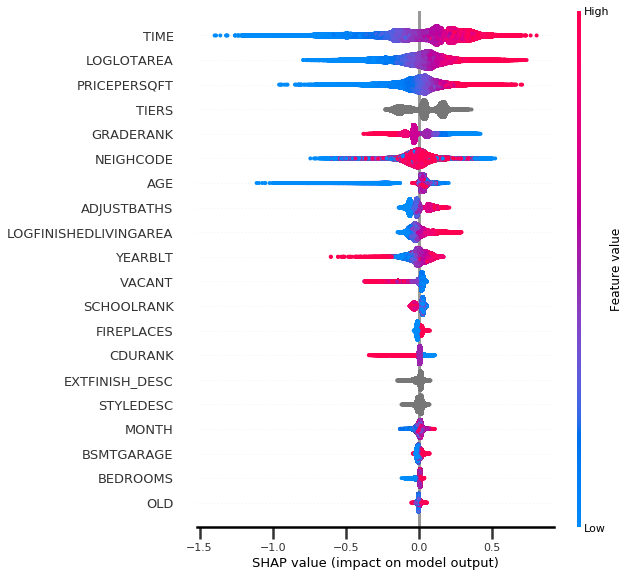

In [14]:
shap.summary_plot(shap_values, train_dat[x_feats + x_categorical_feats], show=False)
plt.savefig("%s/shap_summary_model.png" % image_path, format='png', dpi=300, bbox_inches='tight')

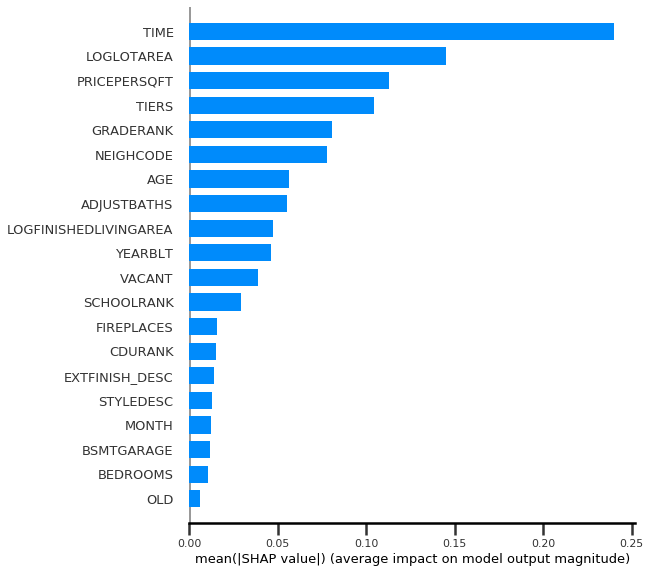

In [15]:
shap.summary_plot(shap_values, train_dat[x_feats + x_categorical_feats], plot_type="bar", show=False)
plt.savefig("%s/shap_summary_bar_model.png" % image_path, format='png', dpi=300, bbox_inches='tight')

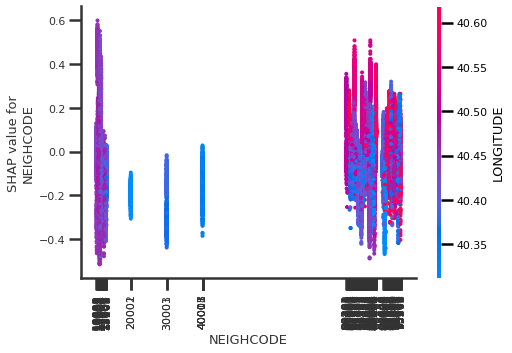

In [16]:
shap.dependence_plot('NEIGHCODE', shap_values, train_dat[x_feats + x_categorical_feats])

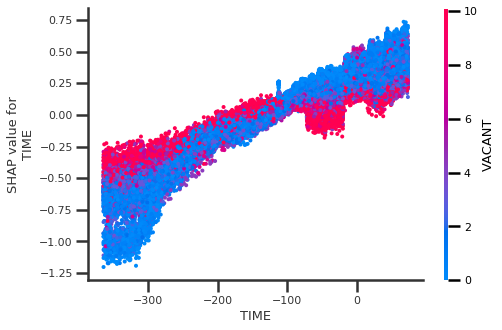

In [17]:
shap.dependence_plot('TIME', shap_values, train_dat[x_feats + x_categorical_feats])

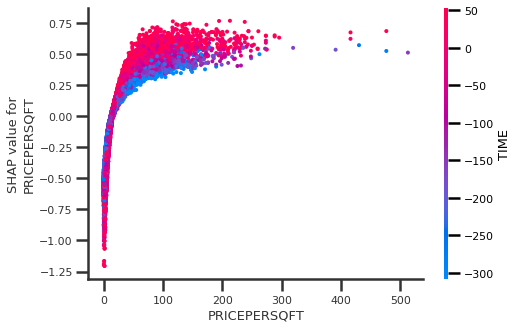

In [20]:
shap.dependence_plot('PRICEPERSQFT', shap_values, train_dat[x_feats + x_categorical_feats])

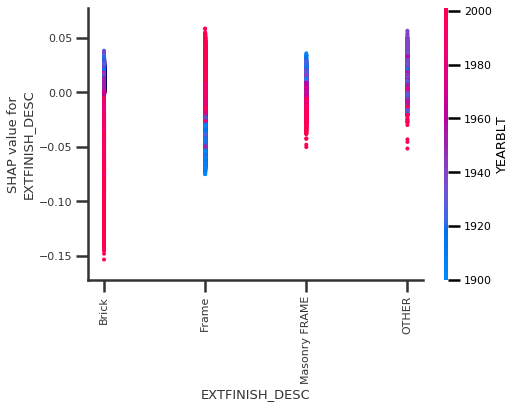

In [23]:
shap.dependence_plot('EXTFINISH_DESC', shap_values, train_dat[x_feats + x_categorical_feats])

In [24]:
 pearsonr(train_dat["YEARBLT"], train_dat["AGE"])

(-0.9506785800969288, 0.0)